# RNN Testing

In [10]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
%reload_ext autoreload

In [12]:
import sys
import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

sys.path.append('../scripts')
import ml_helper as mlh
import ml_evaluation as mle
import rnn
from rnn import RNN
import Baseline_classifiers as bc


In [13]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [14]:
organisms = ["E.Coli", "Drosophila.Melanogaster", "Homo.Sapiens"]
organism = organisms[0]
print(organism)
batch_size = 1
min_length = None
max_length = None
padding_pos = "right" if batch_size > 1 else None
shuffled = False

test_dataset = mlh.CodonDataset(organism=organism, split="test", shuffled=shuffled, min_length=min_length, max_length=max_length, padding_pos=padding_pos)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
print("Länge test_dataset:", len(test_dataset))

E.Coli
Länge test_dataset: 386


### Load all trained RNN models

In [15]:
# test all models and save the best one for further evaluation
all_trained_models = mlh.load_model("rnn", organism, device=device, get_all=True)

rnnModel = None
accuracy = 0
predicted = None
labels = None

for trained_model in all_trained_models:
    name, model = trained_model.values()
    pre, lab, acc = rnn.evaluate(model, test_loader, device=device)
    if acc > accuracy:
        rnnModel, predicted, labels, accuracy = model, pre, lab, acc
    print(f"{name:<65} Accuracy: {acc*100:.2f}%")

print("="*100)
print(f"best model with Accuracy {accuracy*100:.2f}%")
print(f"{model}")

Loaded 1 models
20240521135840_rnn_hidden128_epochs10_lr0.001_optimSGD.pt         Accuracy: 52.56%
best model with Accuracy 52.56%
RNN(
  (i2h): Linear(in_features=22, out_features=128, bias=False)
  (h2h): Linear(in_features=128, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=65, bias=True)
)


In [16]:
predicted.shape

(118513,)

In [17]:
predicted_codon_names =  mle.codon_to_name(predicted)
labels_codon_names =  mle.codon_to_name(labels)

predicted_aa =  mle.translate_codons(predicted_codon_names)
labels_aa =  mle.translate_codons(labels_codon_names)

mle.get_unique_pred_classes(predicted_codon_names, labels_codon_names)
mle.print_unique_elements(predicted_aa, labels_aa)

accuracy_aa = accuracy_score(labels_aa, predicted_aa)
print(f'Accuracy of amino acids: {accuracy_aa*100:.2f}%')

predicted different classes:  51 out of: 61
predicted following classes:  {'GAG', 'GCG', 'CCG', 'TCA', 'TGC', 'CCA', 'TCC', 'CCC', 'GTT', 'AAA', 'GGA', 'CTG', 'TGG', 'GCA', 'AGC', 'CGT', 'GGT', 'TCT', 'GCC', 'GAT', 'ACT', 'TTC', 'CAA', 'CAT', 'TGT', 'CTT', 'TTT', 'TAC', 'CTC', 'AAC', 'ACG', 'GAC', 'GGC', 'GTA', 'ATC', 'GTG', 'ACC', 'AGT', 'GGG', 'CAG', 'TCG', 'GTC', 'ATT', 'TTA', 'AAT', 'TAT', 'CAC', 'ACA', 'GAA', 'ATG', 'CGC'}
predicted different amino acids:  20 out of: 20
Accuracy of amino acids: 100.00%


## Plots

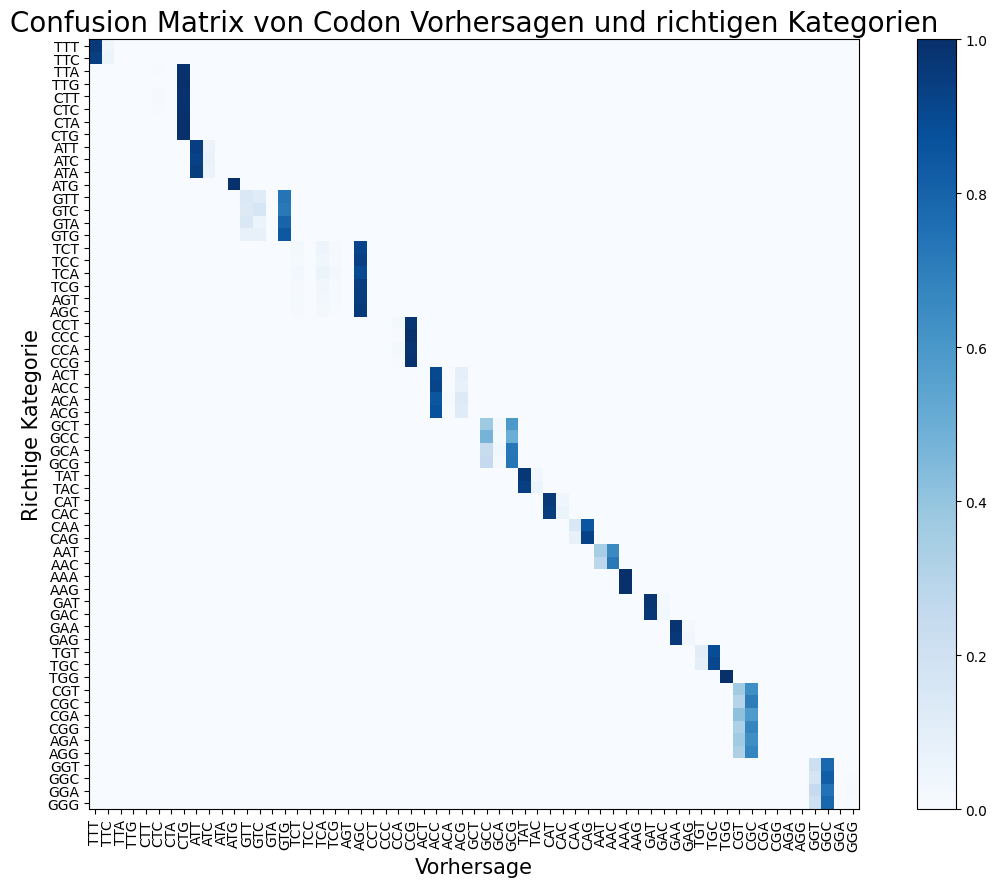

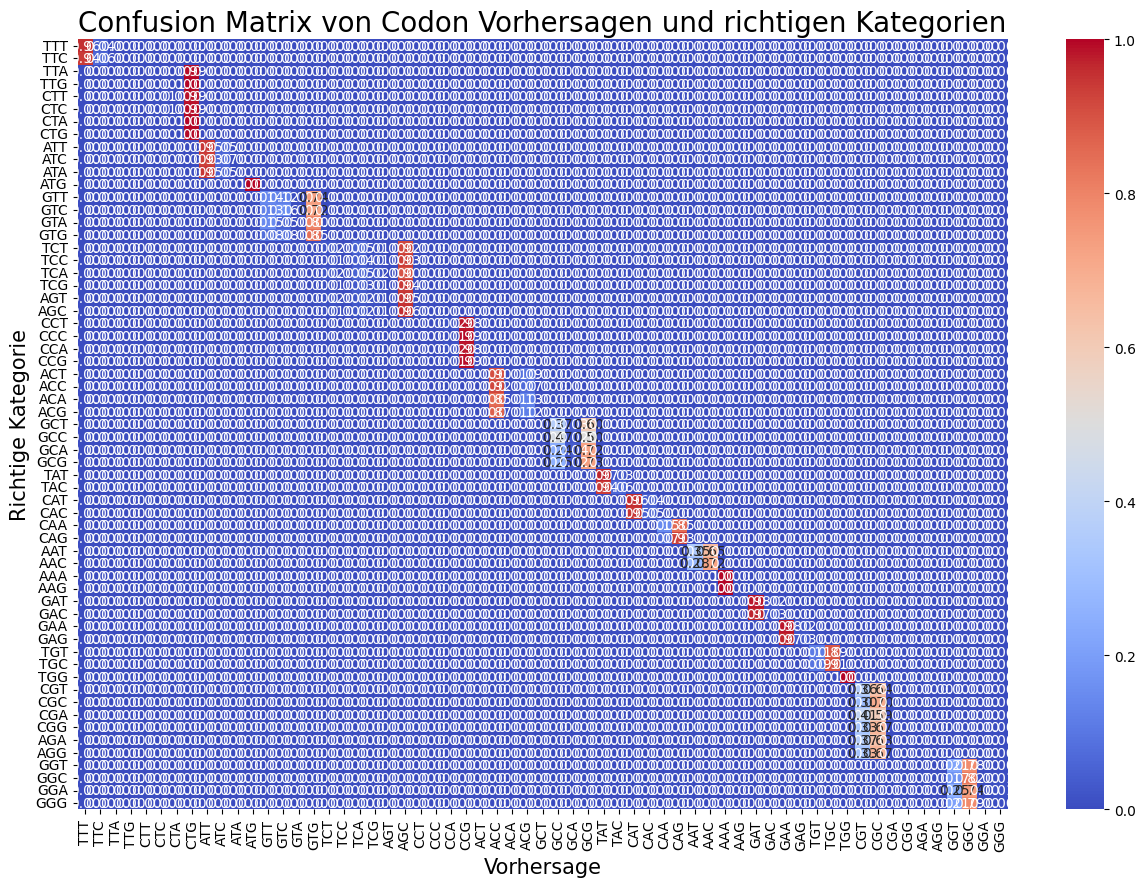

In [18]:
title = 'Confusion Matrix von Codon Vorhersagen und richtigen Kategorien'

codons = [c for c in mlh.codons if c != '___']

plt = mle.plot_confusion_matrix(labels, predicted, mlh.codons_sorted, title, sort_codons=True)
plt.show()
plt = mle.plot_confusion_matrix_sns(labels, predicted, mlh.codons_sorted, title, sort_codons=True)
plt.show()

### Aminosäuren Accuracy

$$A\_Acc = \frac{T\_a}{G\_a} $$

- $T\_a$: Anzahl der richtig klassifizierten ausgewählten Aminosäure über alle Testsequenzen eines betrachteten Organismus
- $G\_a$: Gesamtanzahl der ausgewählten Aminosäure über alle Testsequenzen eines betrachteten Organismus

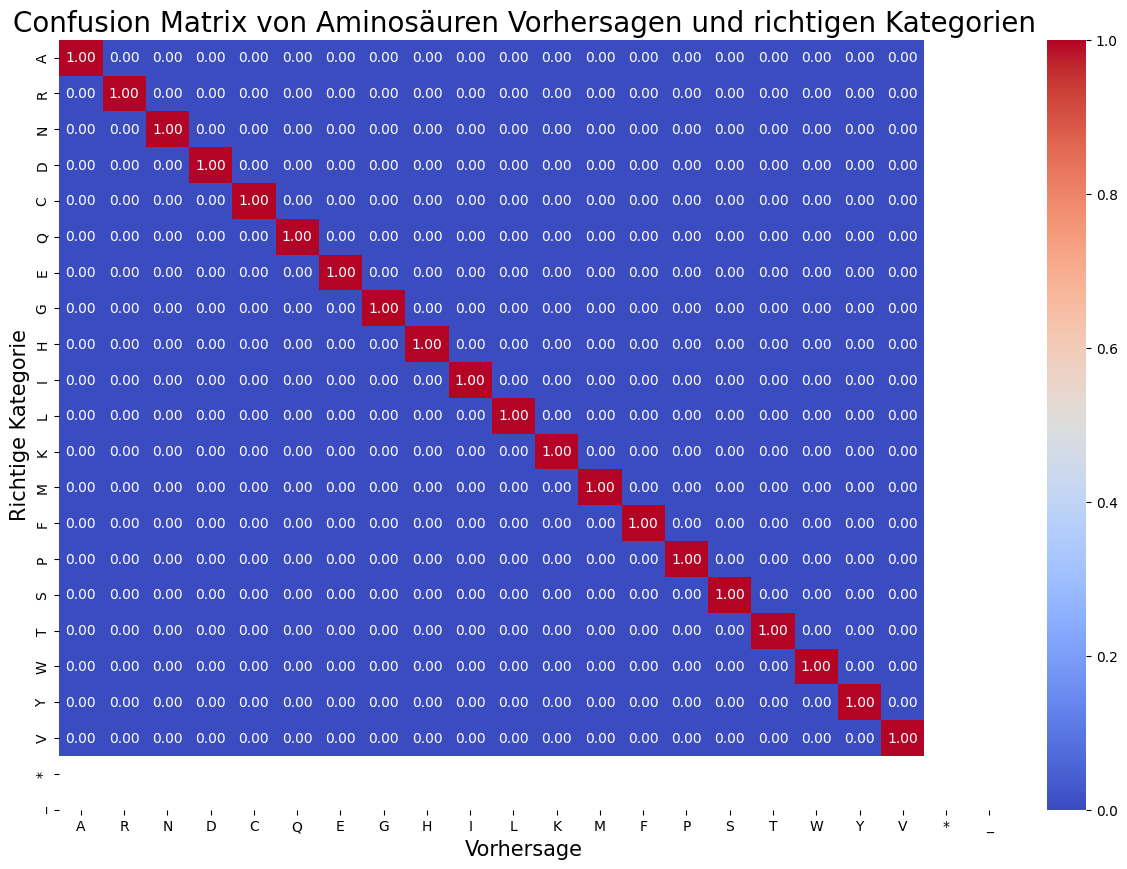

In [19]:
# Calculate confusion matrix for amino acids

plt = mle.plot_confusion_matrix_sns(labels_aa, predicted_aa, mlh.amino_acids, 
                                        'Confusion Matrix von Aminosäuren Vorhersagen und richtigen Kategorien')
plt.show()

{'ATG': 3365, 'CGA': 0, 'CAT': 1503, 'CCT': 0, 'TTA': 5, 'GTG': 2599, 'GGT': 657, 'AAC': 1962, 'TGG': 1761, 'AAA': 4148, 'CTG': 6373, 'GGC': 2885, 'AGC': 1814, 'CGC': 1726, 'CAC': 60, 'GTT': 321, 'GAG': 70, 'TCT': 23, 'CGT': 935, 'GCA': 91, 'GCT': 0, 'TGT': 62, 'GCG': 2905, 'ATC': 207, 'CCA': 19, 'CCG': 2753, 'GAA': 4657, 'TAT': 1828, 'GAT': 3770, 'AAG': 0, 'CAA': 269, 'GAC': 67, 'TCC': 3, 'TTC': 122, 'ACC': 2650, 'CAG': 3245, 'TAC': 88, 'ACT': 2, 'TGC': 679, 'AAT': 722, 'GTA': 3, 'ATT': 3438, 'TTT': 2507, 'GCC': 1453, 'TTG': 0, 'CTT': 1, 'ATA': 0, 'AGA': 0, 'GTC': 280, 'AGT': 0, 'ACG': 190, 'CGG': 0, 'TCA': 44, 'CTA': 0, 'CTC': 8, 'ACA': 10, 'AGG': 0, 'GGA': 0, 'TCG': 11, 'CCC': 0, 'GGG': 5}


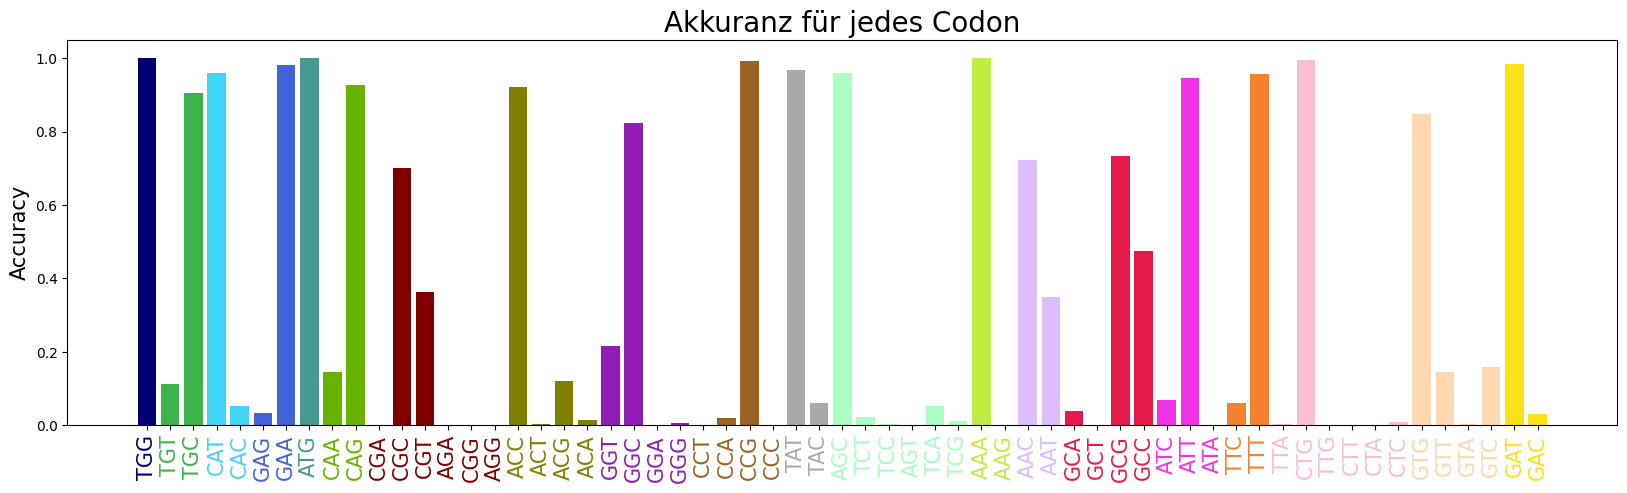

In [20]:
plt = mle.plot_codon_acc(labels, predicted, 'Akkuranz für jedes Codon')

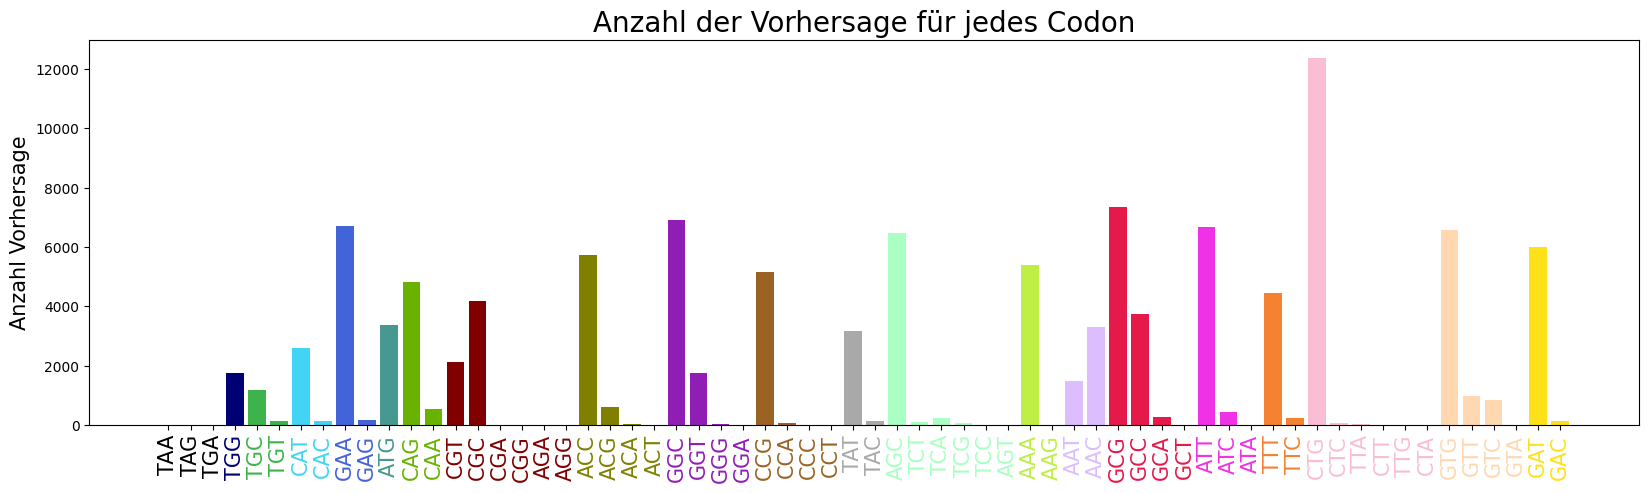

In [21]:
codon_counted_predicted = mle.codon_count(predicted)

plt = mle.plot_codon_count(codon_counted_predicted, 'Anzahl der Vorhersage für jedes Codon')

### Durchschnittliche Codon Accuracy

$$Avg\_CACC = \frac{\sum_{sc \in SC} c\_acc\{sc\}}{|SC|} $$

- $c\_acc$: Codon Accuracy
- $SC$: Synonyme Codons für die ausgewählte Aminosäure über alle Testsequenzen eines betrachteten Organismus

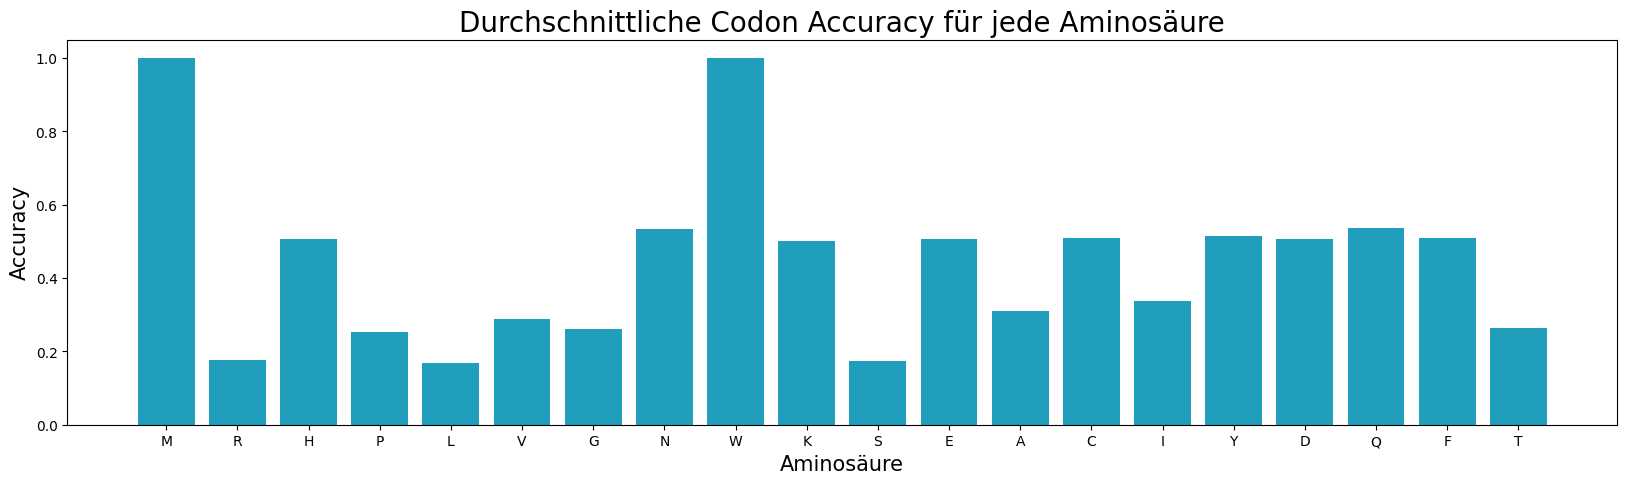

In [22]:
mle.plot_avg_aa_acc(labels, predicted).show()

### Diagramme

In [23]:
results = {
    "E.Coli": {
        "Max CUB": 0.5186,
        "RNN": 0.5256,
        "RNN shuffled": 0.5096,
    },
    "Fruchtfliege": {
        "Max CUB": 0.4917,
        "RNN": 0.4969,
        "RNN shuffled": 0.4832,
    },
    "Mensch": {
        "Max CUB": 0.438,
        "RNN": 0.4583,
        "RNN shuffled": 0.5264,
    }
}

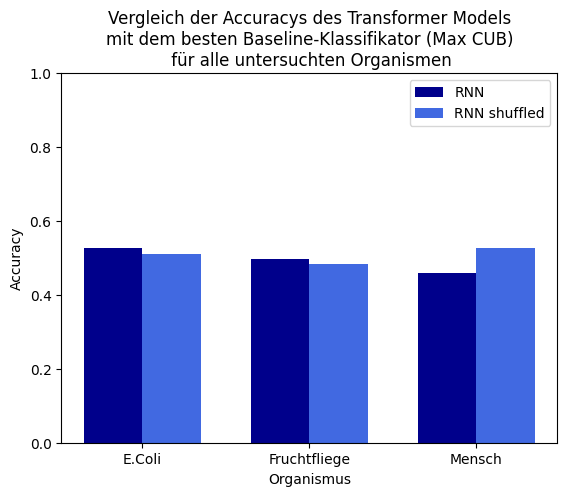

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
organisms = list(results.keys())
max_cub_values = [results[org]["Max CUB"] for org in organisms]
rnn_unshuffled = [results[org]["RNN"] for org in organisms]
rnn_shuffled = [results[org]["RNN shuffled"] for org in organisms]

# Number of bars
x = np.arange(len(organisms))

# Bar width
width = 0.35

# Create the plot
fig, ax = plt.subplots()

# Plotting the bars
bars1 = ax.bar(x - width/2, rnn_unshuffled, width, label='RNN', color='darkblue')
bars2 = ax.bar(x + width/2, rnn_shuffled, width, label='RNN shuffled', color='#4169e1')


# Adding labels and title
ax.set_xlabel('Organismus')
ax.set_ylabel('Accuracy')
ax.set_title('Vergleich der Accuracys des Transformer Models\nmit dem besten Baseline-Klassifikator (Max CUB)\n für alle untersuchten Organismen')
ax.set_xticks(x)
ax.set_xticklabels(organisms)
ax.set_ylim(0, 1)
ax.legend()

# Display the plot
plt.show()


### RNN Classifier

Datensatz geladen für E.Coli
Model loaded: 20240521135840_rnn_hidden128_epochs10_lr0.001_optimSGD.pt


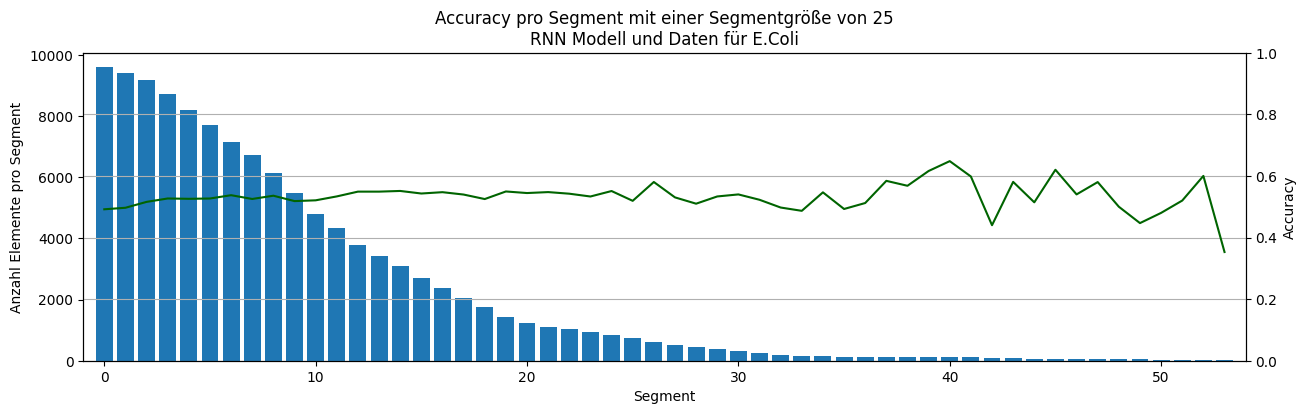

Datensatz geladen für Drosophila.Melanogaster
Model loaded: 20240522164142_rnn_hidden128_epochs3_lr0.001_optimSGD.pt


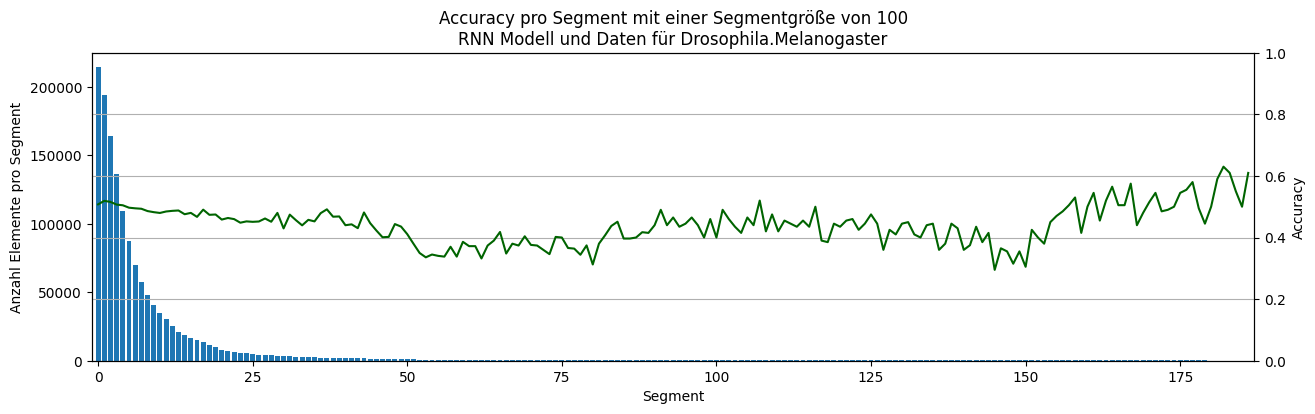

Datensatz geladen für Homo.Sapiens
Model loaded: 20240605214448_rnn_hidden128_epochs8_lr0.001_optimRMSprop.pt


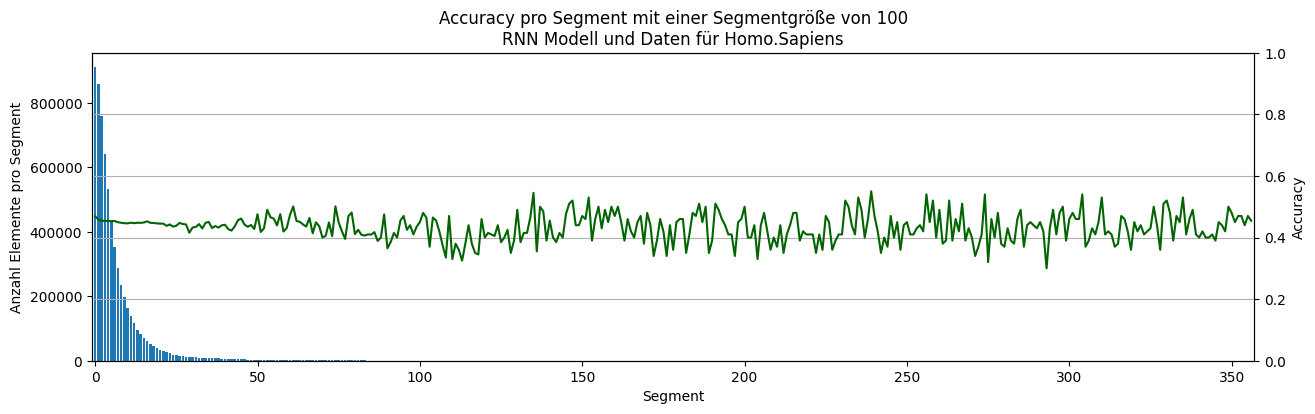

In [36]:
for (org, segment_size) in [("E.Coli", 25), ("Drosophila.Melanogaster", 100), ("Homo.Sapiens", 100)]:
    test_dataset = mlh.CodonDataset(organism=org, split="test", padding_pos=None)
    test_loader = DataLoader(test_dataset, batch_size=1)
    print(f"Datensatz geladen für {org}")

    # test all models and save the best one for further evaluation
    rnnModel = mlh.load_model("rnn", org, device=device)

    classifier = rnn.RNN_Classifier(rnnModel)
    pred, labels = classifier.predict_codons(test_loader)

    seg_acc, seg_el = classifier.calc_accuracy_per_segment(labels, pred, segment_size=segment_size)
    mle.plot_accuracies_per_segment(seg_acc, seg_el, f"Accuracy pro Segment mit einer Segmentgröße von {segment_size}\nRNN Modell und Daten für {org}")